<a href="https://colab.research.google.com/github/antoniovfonseca/summarize-change-components/blob/main/summarize_change_components_westernBahia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1.Environment Setup**


---



### **1.1.Install Python Libraries**


In [ ]:
%pip -q install \
    rasterio \
    seaborn \
    xlsxwriter \
    matplotlib-scalebar \
    matplotlib-map-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 93.3 MB/s eta 0:00:00


### **1.2.Importing Libraries**

In [20]:
# Standard library
import glob
import os
import pickle
import sys
import time

# Typing for annotations
from typing import Dict, List, Optional  # NEW

# Third-party
import numba as nb
import numpy as np
import pandas as pd
import rasterio
import xlsxwriter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from numba import prange
from pyproj import Transformer
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Rasterio submodules
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling

# Matplotlib extensions
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils import north_arrow  # scale_bar removed
from matplotlib.colors import (
    ListedColormap,
    BoundaryNorm,
    Normalize,
    LinearSegmentedColormap,
)
from matplotlib.patches import Patch, Rectangle, FancyArrowPatch

### **1.3.Mounting Google Drive in Colab**



In [ ]:
# Run only if using Google Colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## **2.Data Preparation**

### **2.1.Setting Paths to Image Files**

The user must include the year in the raster map name.

In [4]:
# List of input raster paths
image_paths = [
    r"/mnt/c/Users/AntFonseca/github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_1990.tif",
    r"/mnt/c/Users/AntFonseca/github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_1995.tif",
    r"/mnt/c/Users/AntFonseca/github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_2000.tif",
    r"/mnt/c/Users/AntFonseca/github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_2005.tif",
    r"/mnt/c/Users/AntFonseca/github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_2010.tif",
    r"/mnt/c/Users/AntFonseca/github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_2015.tif",
    r"/mnt/c/Users/AntFonseca/github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_2020.tif",
]

# Raster mask path
mask_path = r"/mnt/c/Users/AntFonseca/github/1.INPUT/summarize-patterns/WESTERN/WesternBahiaMask.tif"

# Check if all files exist
all_files = image_paths + [mask_path]
missing_files = [f for f in all_files if not os.path.exists(f)]

if missing_files:
    print("Missing files:")
    for f in missing_files:
        print(" -", f)
else:
    print("All input files found.")

All input files found.


### **2.2.Setting Path to Output Files**

In [5]:
# Output directory path
output_path = r"/mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output"

# Create folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print("Folder created:", output_path)
else:
    print("Folder already exists:", output_path)

Folder created: /mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output


### **2.3.Setting Years of the Time Intervals**

In [6]:
# Years of input rasters
years = [1990, 1995, 2000, 2005, 2010, 2015, 2020]

### **2.4.Setting the classes**

In [7]:
# Class ID, names, and colors
class_labels_dict = {
     0: {"name": "Backgroud",                  "rename": "Background", "color": "#ffffff"},
     4: {"name": "Savanna Formation",          "rename": "Savanna",    "color": "#ff0000"},
    12: {"name": "Grassland",                  "rename": "Grassland",  "color": "#8b0000"},
     3: {"name": "Forest Formation",           "rename": "Forest",     "color": "#ffffcc"},
    33: {"name": "River, Lake and Ocean",      "rename": "Water",      "color": "#ffff99"},
    46: {"name": "Coffee",                     "rename": "Coffee",     "color": "#ffff66"},
    29: {"name": "Rocky Outcrop",              "rename": "Rocky",      "color": "#ffff00"},
    11: {"name": "Wetland",                    "rename": "Wetland",    "color": "#cc9900"},
    24: {"name": "Urban Area",                 "rename": "Urban",      "color": "#ffcccc"},
     9: {"name": "Forest Plantation",          "rename": "Plantation", "color": "#ffcc99"},
    48: {"name": "Other Perennial Crops",      "rename": "Perennial",  "color": "#ffcc66"},
    25: {"name": "Other non Vegetated Areas",  "rename": "Barren",     "color": "#ffcc00"},
    21: {"name": "Mosaic of Uses",             "rename": "Mosaic",     "color": "#ff9900"},
    62: {"name": "Cotton (beta)",              "rename": "Cotton",     "color": "#ff66ff"},
    15: {"name": "Pasture",                    "rename": "Pasture",    "color": "#cc00cc"},
    41: {"name": "Other Temporary Crops",      "rename": "Temporary",  "color": "#0000ff"},
    39: {"name": "Soybean",                    "rename": "Soybean",    "color": "#00bfff"},
}


# Sorted list of renamed class labels
class_labels = [class_labels_dict[key]["rename"] for key in sorted(class_labels_dict.keys())]

### **2.4.Apply Mask**

In [8]:
def apply_mask_to_images(image_paths, output_path, mask_path=None):
    """
    Apply a mask to raster images and save as 8-bit TIFFs.

    Args:
        image_paths (list[str]): Paths to input images.
        output_path (str): Directory to save masked images.
        mask_path (str, optional): Path to mask raster.

    Returns:
        list[str]: Paths to saved masked images.
    """
    # Create output folder if missing
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    saved_paths = []

    # Load mask if provided
    mask_data = None
    if mask_path:
        with rasterio.open(mask_path) as mask_file:
            mask_data = mask_file.read(1)

    # Apply mask to each image
    for path in image_paths:
        with rasterio.open(path) as image:
            meta = image.meta.copy()

            # Force 8-bit TIFF settings
            meta["dtype"] = "uint8"
            meta["nodata"] = 0
            meta["driver"] = "GTiff"
            meta["compress"] = "lzw"

            # Read raster band and apply mask
            image_data = image.read(1)
            if mask_data is not None:
                masked_data = (image_data * (mask_data == 1)).astype("uint8")
            else:
                masked_data = image_data.astype("uint8")

            # Build output path
            base_name = os.path.basename(path).replace(".tif", "_masked.tif")
            masked_path = os.path.join(output_path, base_name)

            # Save masked image
            with rasterio.open(masked_path, "w", **meta) as dest:
                dest.write(masked_data, 1)

            saved_paths.append(masked_path)

    return saved_paths


# Apply mask and save results
masked_image_paths = apply_mask_to_images(image_paths, output_path, mask_path)

# Print saved paths
for path in masked_image_paths:
    print(path)

/mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output/lulc_mapbiomas_1990_masked.tif
/mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output/lulc_mapbiomas_1995_masked.tif
/mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output/lulc_mapbiomas_2000_masked.tif
/mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output/lulc_mapbiomas_2005_masked.tif
/mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output/lulc_mapbiomas_2010_masked.tif
/mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output/lulc_mapbiomas_2015_masked.tif
/mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output/lulc_mapbiomas_2020_masked.tif


### **2.5.Display the Maps**

The code defines a function to find files with a given suffix and returns their paths. It then defines a function that plots each raster file with a specified color map, and a legend. It reads the raster data with rasterio, reshapes it, applies the color map, and arranges the images in a single row of subplots. It sets each plot’s title with the provided year, hides the axes, and includes a custom legend. Finally, it saves the plot as a JPEG and displays it.

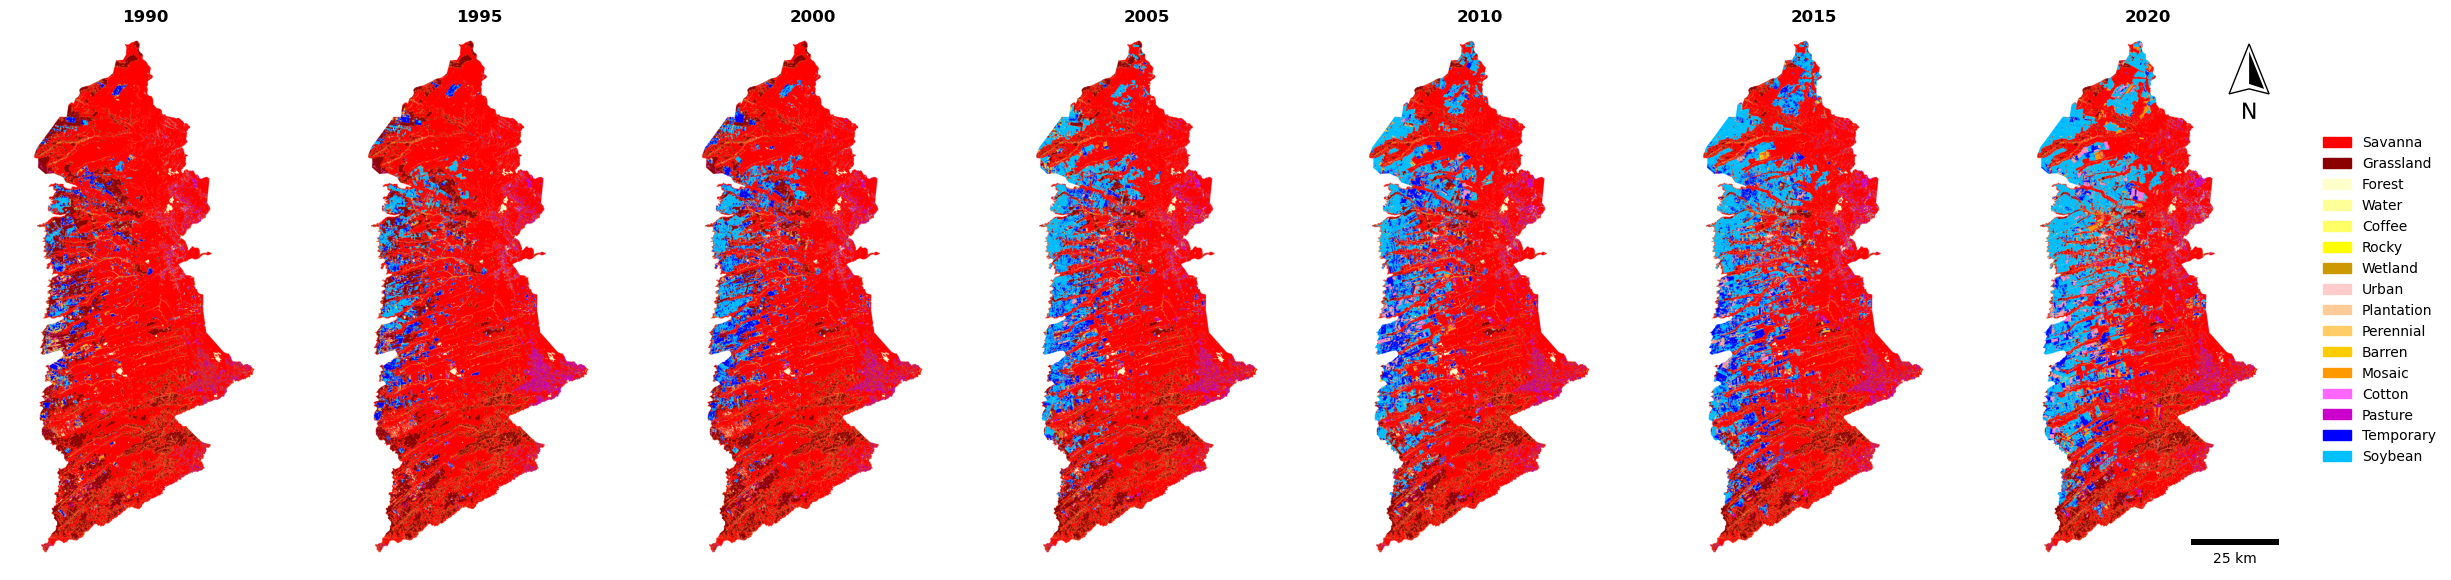

In [ ]:
def plot_classified_images(
    image_paths: List[str],
    class_map: Dict[int, Dict[str, str]],
    years: List[int],
    output_path: str,
    downsample_divisor: int = 4,             # display downsample
    panel_size: tuple = (4.0, 6.0),          # width, height per panel (inches)
    dx_km: Optional[float] = None,           # pixel size in km; auto if None (projected CRS)
    resampling_method: Resampling = Resampling.bilinear,  # match your original
) -> None:
    """Plot classified rasters with legend, north arrow, and km scale bar."""
    if not image_paths:
        raise ValueError("image_paths is empty.")
    if len(image_paths) != len(years):
        raise ValueError("image_paths and years must match in length.")

    # Figure (tighter spacing; room on the right for legend)
    n_images = len(image_paths)
    fig, axs = plt.subplots(
        1,
        n_images,
        figsize=(panel_size[0] * n_images, panel_size[1]),
        sharey=True,
        constrained_layout=False,
    )
    plt.subplots_adjust(
        left=0.02,
        right=0.85,
        top=0.95,
        bottom=0.05,
        wspace=0.04,
    )

    # Colormap and norm
    class_ids_sorted = sorted(class_map.keys())
    cmap = ListedColormap([class_map[k]["color"] for k in class_ids_sorted])
    norm = BoundaryNorm(class_ids_sorted + [class_ids_sorted[-1] + 1], cmap.N)

    # Auto dx_km from first raster if projected in meters
    if dx_km is None:
        with rasterio.open(image_paths[0]) as src0:
            if src0.crs and src0.crs.is_projected:
                dx_km = abs(src0.transform.a) / 1000.0
            else:
                raise ValueError("dx_km is required when CRS is geographic (degrees).")

    # Plot rasters
    axes = axs if n_images > 1 else [axs]
    for i, (path, ax) in enumerate(zip(image_paths, axes)):
        with rasterio.open(path) as src:
            h = max(1, src.height // downsample_divisor)
            w = max(1, src.width // downsample_divisor)
            data = src.read(1, out_shape=(h, w), resampling=resampling_method)
        ax.imshow(data, cmap=cmap, norm=norm)
        ax.set_title(f"{years[i]}", fontweight="bold")
        ax.axis("off")

    # Legend: keep insertion order from class_map (exclude 0)
    legend_ids = [k for k in class_map.keys() if k != 0]
    legend_elements = [
        Rectangle((0, 0), 1, 1, color=class_map[k]["color"], label=class_map[k]["rename"])
        for k in legend_ids
    ]
    fig.legend(
        handles=legend_elements,
        loc="center right",
        bbox_to_anchor=(0.9, 0.5),
        frameon=False,
    )

    # Scale bar in km
    scalebar = ScaleBar(
        dx=dx_km,
        units="km",
        length_fraction=0.4,
        location="lower right",
        scale_loc="bottom",
        color="black",
        box_alpha=0,
    )
    axes[-1].add_artist(scalebar)

    # North arrow on last axis
    north_arrow(
        axes[-1],
        location="upper right",
        shadow=False,
        rotation={"degrees": 0},
    )

    # Save
    out_fig = os.path.join(output_path, "plot_input_maps.jpeg")
    plt.savefig(
        out_fig,
        format="jpeg",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()
    plt.close()


# Call
plot_classified_images(
    masked_image_paths,
    class_labels_dict,
    years,
    output_path,
)

## **3.Generate the Transition Matrix**


---
In this section, the computer code will generate four different transition matrices. The first one is related to each time interval. The second one is the transition matrix for the temporal extent, which is represented for the first and last time point of the time extent. The third one is a transition matrix that represents the sum of all time intervals. And the last transition matrix is the alternation matrix, which is the sum matrix minus the extent matrix.

Before generate the transition matrix, the computer code will analyze the presence of 0, NULL and NA value in all maps. If there is a presence of one of these values, the computer code will create a mask with these values and will remove all the pixels in the same position in all maps and years.

All the transition matrix will be salved in the Google Drive in the ".csv" format.

In [ ]:
# Generate the Transition Matrix
def generate_mask_and_flatten_rasters(output_path, suffix='_masked.tif'):
    """
    Reads rasters with a specific suffix from a directory, applies a mask where
    data is zero, missing, or NaN, and flattens the non-masked values.

    Parameters:
    output_path (str): Directory containing raster files to process.
    suffix (str): File suffix to identify relevant rasters.

    Returns:
    list of numpy arrays: Flattened arrays of non-masked raster data for further analysis.
    """
    image_paths = [os.path.join(output_path, f)
                   for f in os.listdir(output_path) if f.endswith(suffix)]
    image_paths.sort()

    all_data = []
    all_masks = []

    # Read and mask all rasters
    for path in image_paths:
        with rasterio.open(path) as src:
            data = src.read(1)
            mask = (data == 0) | (data == src.nodata) | np.isnan(data)
            all_masks.append(mask)
            all_data.append(data)

    # Create combined mask
    combined_mask = np.any(all_masks, axis=0)

    # Return flattened data
    return [data[~combined_mask].flatten() if np.any(combined_mask)
            else data.flatten() for data in all_data]

transition_matrix = confusion_matrix

def generate_all_matrices(output_path, suffix='_masked.tif'):
    """Generate all required matrices and save to CSV"""
    global years

    # Get processed data
    flattened_data = generate_mask_and_flatten_rasters(output_path, suffix)

    # Validate year count
    if len(years) != len(flattened_data):
        raise ValueError(f"Mismatch: {len(years)} years vs {len(flattened_data)} rasters")

    # Get class labels from data
    all_classes = np.unique(np.concatenate(flattened_data)).astype(int)

    # Generate interval matrices
    for i in range(len(flattened_data)-1):
        cm = transition_matrix(flattened_data[i],
                              flattened_data[i+1],
                              labels=all_classes)
        pd.DataFrame(cm,
                     index=all_classes,
                     columns=all_classes
        ).to_csv(os.path.join(output_path,
                              f'transition_matrix_{years[i]}-{years[i+1]}.csv'))

    # Generate extent matrix
    extent_matrix = transition_matrix(flattened_data[0],
                                     flattened_data[-1],
                                     labels=all_classes)
    pd.DataFrame(extent_matrix,
                 index=all_classes,
                 columns=all_classes
    ).to_csv(os.path.join(output_path,
                          f'transition_matrix_extent_{years[0]}-{years[-1]}.csv'))

    # Generate sum matrix
    sum_matrix = np.zeros((len(all_classes), len(all_classes)), dtype=int)
    for i in range(len(flattened_data)-1):
        sum_matrix += transition_matrix(flattened_data[i],
                                       flattened_data[i+1],
                                       labels=all_classes)
    pd.DataFrame(sum_matrix,
                 index=all_classes,
                 columns=all_classes
    ).to_csv(os.path.join(output_path,
                          f'transition_matrix_sum_{years[0]}-{years[-1]}.csv'))

    # Generate alternation matrix
    alternation_matrix = sum_matrix - extent_matrix
    pd.DataFrame(alternation_matrix,
                 index=all_classes,
                 columns=all_classes
    ).to_csv(os.path.join(output_path,
                          f'transition_matrix_alternation_{years[0]}-{years[-1]}.csv'))

    return years, all_classes

def main(output_path):
    """Matrix generation workflow"""
    # Create output directory if needed
    os.makedirs(output_path, exist_ok=True)

    # Generate all matrices
    print("Generating transition matrices...")
    years, all_classes = generate_all_matrices(output_path)

    print(f"Detected classes: {all_classes}")
    print("Matrices saved in:", output_path)

if __name__ == "__main__":
    main(output_path)

Generating transition matrices...
Detected classes: [ 3  4  9 11 12 15 21 24 25 29 33 39 41 46 48 62]
Matrices saved in: /content/drive/MyDrive/change-components/output


## **4.Components of Change**


---
The code calculates components of change from transition matrices generated in the previous step. It features a ComponentCalculator class that processes matrices to determine the gain and loss of Quantity, Exchange, and Shift. The process_matrix function handles matrices for defined time intervals and the main function systematically processes these matrices for each time interval, aggregates the results, and exports the outcomes to a CSV file.

In [ ]:
class ComponentCalculator:
    def __init__(self, transition_matrix):
        self.matrix = transition_matrix.astype(int)
        self.num_classes = transition_matrix.shape[0]
        self.class_components = []
        self.total_components = {
            'Quantity_Gain': 0, 'Quantity_Loss': 0,
            'Exchange_Gain': 0, 'Exchange_Loss': 0,
            'Shift_Gain': 0, 'Shift_Loss': 0
        }

    def calculate_components(self):
        for class_idx in range(self.num_classes):
            gain_sum = np.sum(self.matrix[:, class_idx])
            loss_sum = np.sum(self.matrix[class_idx, :])

            q_gain = max(0, gain_sum - loss_sum)
            q_loss = max(0, loss_sum - gain_sum)

            mutual = np.sum(np.minimum(
                self.matrix[class_idx, :],
                self.matrix[:, class_idx]
            ))
            exchange = mutual - self.matrix[class_idx, class_idx]

            total_trans = loss_sum - self.matrix[class_idx, class_idx]
            shift = max(0, total_trans - q_loss - exchange)

            self.class_components.append({
                'Quantity_Gain': q_gain,
                'Quantity_Loss': q_loss,
                'Exchange_Gain': exchange,
                'Exchange_Loss': exchange,
                'Shift_Gain': shift,
                'Shift_Loss': shift
            })
        return self

def process_matrix(matrix_type, start_year=None, end_year=None):
    results = []
    fname = None

    try:
        # Determine filename
        if matrix_type == 'interval':
            fname = f'transition_matrix_{start_year}-{end_year}.csv'
        elif matrix_type == 'extent':
            fname = f'transition_matrix_extent_{years[0]}-{years[-1]}.csv'
        elif matrix_type == 'sum':
            fname = f'transition_matrix_sum_{years[0]}-{years[-1]}.csv'
        elif matrix_type == 'alternation':
            fname = f'transition_matrix_alternation_{years[0]}-{years[-1]}.csv'

        # Validate file path
        full_path = os.path.join(output_path, fname)
        if not os.path.exists(full_path):
            raise FileNotFoundError(f"File {full_path} does not exist")

        # Process data
        df = pd.read_csv(full_path, index_col=0)
        matrix_classes = [int(c) for c in df.index]
        calc = ComponentCalculator(df.values).calculate_components()

        # Build results
        for idx, class_id in enumerate(matrix_classes):
            cls_name = class_labels_dict.get(class_id, {}).get("rename", f"Unknown_{class_id}")
            comp = calc.class_components[idx]

            for component in ['Quantity', 'Exchange', 'Shift']:
                component_name = component
                if matrix_type in ['extent', 'sum'] and component in ['Exchange', 'Shift']:
                    component_name = f'Allocation_{component}'

                results.append({
                    'Time_Interval': f"{start_year}-{end_year}" if matrix_type == 'interval' else matrix_type,
                    'Class': cls_name,
                    'Component': component_name,
                    'Gain': comp[f'{component}_Gain'],
                    'Loss': comp[f'{component}_Loss']
                })

    except Exception as e:
        print(f"ERROR in {matrix_type}: {str(e)}")
        return []

    return results

def main(output_path):
    """Main execution flow with enhanced logging"""
    all_results = []
    print("\n=== Starting processing ===")

    # 1. Process interval matrices
    try:
        print("\nProcessing intervals...")
        for i in range(len(years)-1):
            start = years[i]
            end = years[i+1]
            print(f"  - {start}-{end}")
            all_results.extend(process_matrix('interval', start, end))

    except Exception as e:
        print(f"Fatal error in intervals: {str(e)}")
        return

    # 2. Process extent matrix
    try:
        print("\nProcessing extent matrix...")
        all_results.extend(process_matrix('extent', None, None))
    except Exception as e:
        print(f"Fatal error in extent: {str(e)}")
        return

    # 3. Process sum matrix
    try:
        print("\nProcessing sum matrix...")
        all_results.extend(process_matrix('sum', None, None))
    except Exception as e:
        print(f"Fatal error in sum: {str(e)}")
        return

    # 4. Process alternation matrix
    try:
        print("\nAttempting alternation matrix...")
        alternation_path = os.path.join(output_path,
            f'transition_matrix_alternation_{years[0]}-{years[-1]}.csv')

        if os.path.exists(alternation_path):
            df_alt = pd.read_csv(alternation_path, index_col=0)
            calc = ComponentCalculator(df_alt.values).calculate_components()

            for idx, class_id in enumerate(df_alt.index.astype(int)):
                cls_name = class_labels_dict.get(class_id, {}).get("rename", f"Unknown_{class_id}")
                comp = calc.class_components[idx]

                all_results.extend([{
                    'Time_Interval': 'alternation',
                    'Class': cls_name,
                    'Component': 'Alternation_Exchange',
                    'Gain': comp['Exchange_Gain'],
                    'Loss': comp['Exchange_Loss']
                }, {
                    'Time_Interval': 'alternation',
                    'Class': cls_name,
                    'Component': 'Alternation_Shift',
                    'Gain': comp['Shift_Gain'],
                    'Loss': comp['Shift_Loss']
                }])
        else:
            print("Alternation matrix not found - skipping")

    except Exception as e:
        print(f"Non-fatal alternation error: {str(e)}")

    # 5. Final export
    try:
        output_file = os.path.join(output_path, 'change_components.csv')
        pd.DataFrame(all_results).to_csv(output_file, index=False)
        print(f"\n=== Success! Saved to: {output_file} ===")
        print(f"Total records: {len(all_results):,}")

    except Exception as e:
        print(f"\n!!! FATAL EXPORT ERROR: {str(e)} !!!")

if __name__ == "__main__":
    main(output_path)


=== Starting processing ===

Processing intervals...
  - 1990-1995
  - 1995-2000
  - 2000-2005
  - 2005-2010
  - 2010-2015
  - 2015-2020

Processing extent matrix...

Processing sum matrix...

Attempting alternation matrix...

=== Success! Saved to: /content/drive/MyDrive/change-components/output/change_components.csv ===
Total records: 416


## **5.Graphics**

---



### **5.1 Setting the parameters for the graphics**

In [ ]:
# Read the generated CSV file
csv_path = os.path.join(output_path, 'change_components.csv')
df = pd.read_csv(csv_path)

### **5.2 Change Components by Time Interval**


Component Totals by Time Interval (million pixels):

Time Interval: 1990-1995
Exchange: 5.37 M
Quantity: 3.75 M
Shift: 2.27 M

Time Interval: 1995-2000
Exchange: 7.07 M
Quantity: 3.86 M
Shift: 1.15 M

Time Interval: 2000-2005
Exchange: 7.47 M
Quantity: 5.28 M
Shift: 2.93 M

Time Interval: 2005-2010
Exchange: 9.86 M
Quantity: 4.74 M
Shift: 2.42 M

Time Interval: 2010-2015
Exchange: 11.75 M
Quantity: 5.07 M
Shift: 2.44 M

Time Interval: 2015-2020
Exchange: 9.02 M
Quantity: 7.24 M
Shift: 1.60 M


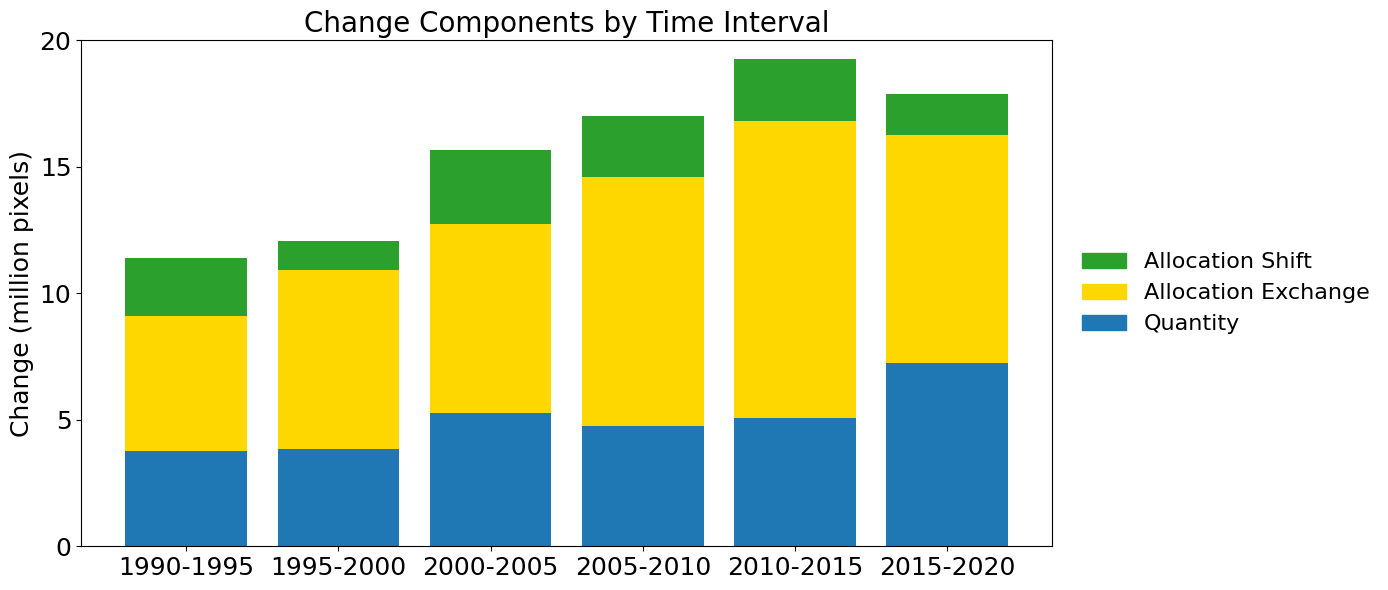

In [ ]:
# Filter only time intervals
time_df = df[df['Time_Interval'].str.contains('-')]

# Prepare data structure
totals = time_df.groupby(['Time_Interval', 'Component'])['Gain'].sum().unstack()

# Print the totals by time interval in millions of pixels
print("\nComponent Totals by Time Interval (million pixels):")
for index, row in totals.iterrows():
    print(f"\nTime Interval: {index}")
    for component in row.index:
        print(f"{component}: {row[component] / 1e6:.2f} M")


# Create figure and axes
fig, ax = plt.subplots(figsize=(14, 6))

# Colors for the bars
colors = [
    '#1f77b4', # Quantity
    '#ffd700', # Exchange
    '#2ca02c'] # Shift

components_color = {
    'Quantity': '#1f77b4',
    'Exchange': '#ffd700',
    'Shift': '#2ca02c'
}

# Plot bars for totals
for idx, comp in enumerate(['Quantity', 'Exchange', 'Shift']):
    bottom_values = totals[['Quantity', 'Exchange', 'Shift']].iloc[:, :idx].sum(axis=1) if idx > 0 else 0
    ax.bar(totals.index,
           totals[comp],
           label=comp,
           color=colors[idx],
           edgecolor='none',
           bottom=bottom_values)

# Formating axes
ax.set_ylabel(
    'Change (million pixels)',
    fontsize=18
)
ax.set_title(
    'Change Components by Time Interval',
    fontsize=20
)
ax.tick_params(
    axis='both',
    which='major',
    labelsize=18
)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Configuring y-axis to scale with millions
def millions_formatter(x, pos):
    return '%1.0f' % (x * 1e-6)
ax.set_ylim(0, 2.0e7)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5_000_000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

# Legend
legend_elements = [
    plt.Rectangle((0,0),1,1, color=components_color['Shift'], label='Allocation Shift'),
    plt.Rectangle((0,0),1,1, color=components_color['Exchange'], label='Allocation Exchange'),
    plt.Rectangle((0,0),1,1, color=components_color['Quantity'], label='Quantity')
]

ax.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    fontsize=16,
    frameon=False
)

# Save and show plot
plt.tight_layout()
plt.savefig(os.path.join(
    output_path,
    "graphic_change_components_time_interval.jpeg"),
    bbox_inches='tight',
    format='jpeg',
    dpi=300
)
plt.show()

### **5.3 Change Components Overall**


Component Totals (million pixels):
Quantity: 23.95 M
Allocation Exchange: 3.79 M
Allocation Shift: 5.39 M
Alternation Exchange: 33.89 M
Alternation Shift: 26.26 M


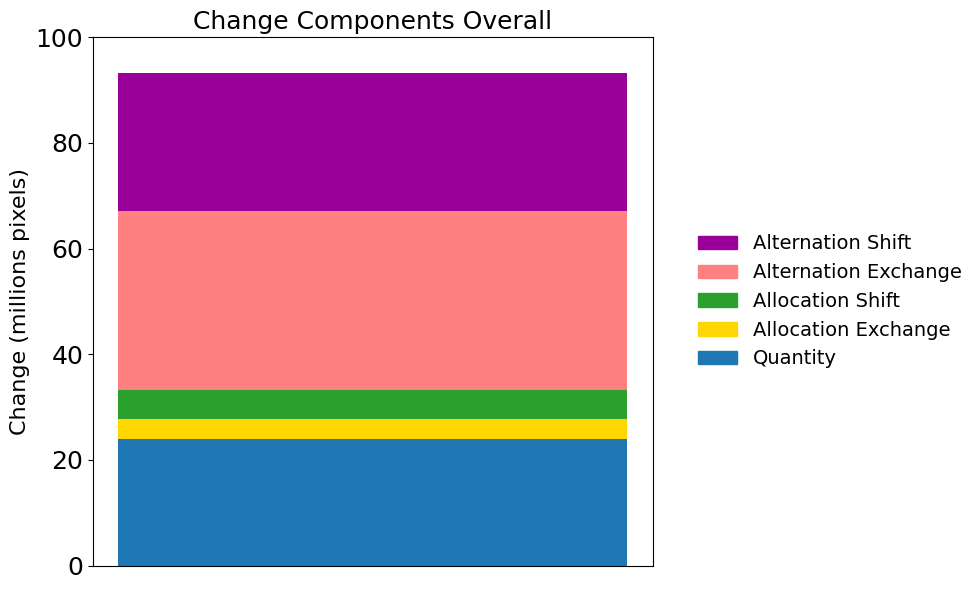

In [ ]:
def plot_components_with_alternation(csv_path, output_path):
    """
    Generates stacked bar chart showing:
    - Quantity (from extent matrix)
    - Exchange + Alternation Exchange
    - Shift + Alternation Shift

    Args:
        csv_path: Path to change_components.csv
        output_path: Directory to save the graphic
    """
    # Load data
    df = pd.read_csv(csv_path)

    # Define colors and component order
    components_color = {
        'Quantity': '#1f77b4',
        'Allocation_Exchange': '#ffd700',
        'Alternation_Exchange': '#ff8080',
        'Allocation_Shift': '#2ca02c',
        'Alternation_Shift': '#990099'
    }

    component_order = [
        'Quantity',
        'Allocation_Exchange',
        'Allocation_Shift',
        'Alternation_Exchange',
        'Alternation_Shift'
    ]

    # Calculate component totals
    component_totals = {
        'Quantity': df[(df['Component'] == 'Quantity') &
                      (df['Time_Interval'] == 'extent')]['Gain'].sum(),

        'Allocation_Exchange': df[(df['Component'] == 'Allocation_Exchange') &
                      (df['Time_Interval'] == 'extent')]['Gain'].sum(),

        'Allocation_Shift': df[(df['Component'] == 'Allocation_Shift') &
                   (df['Time_Interval'] == 'extent')]['Gain'].sum(),

        'Alternation_Exchange': df[df['Component'] == 'Alternation_Exchange']['Gain'].sum(),


        'Alternation_Shift': df[df['Component'] == 'Alternation_Shift']['Gain'].sum()
    }

    # Print dos valores em milhões de pixels
    print("\nComponent Totals (million pixels):")
    for component, value in component_totals.items():
        print(f"{component.replace('_', ' ')}: {value / 1e6:.2f} M")

    # Create figure with original styling
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot stacked bars
    bottom = 0
    bars = []
    labels = []

    for component in component_order:
        value = component_totals.get(component, 0)
        bar = ax.bar(
            x=0,
            height=value,
            bottom=bottom,
            color=components_color[component],
            edgecolor='none',
            width=1
        )
        bars.append(bar[0])
        labels.append(component.replace('_', ' '))
        bottom += value

    # Axis formatting
    ax.set_ylabel(
        'Change (millions pixels)',
        fontsize=16
    )
    ax.set_title(
        'Change Components Overall',
        fontsize=18
    )
    ax.xaxis.set_visible(False)
    ax.tick_params(
        axis='both',
        which='major',
        labelsize=18
    )
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Remove chart borders
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(True)

    # Configuring y-axis to scale with millions
    def millions_formatter(x, pos):
        return '%1.0f' % (x * 1e-6)
    ax.set_ylim(0, 10e7)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20_000_000))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

    # Legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, color=components_color['Alternation_Shift'], label='Alternation Shift'),
        plt.Rectangle((0,0),1,1, color=components_color['Alternation_Exchange'], label='Alternation Exchange'),
        plt.Rectangle((0,0),1,1, color=components_color['Allocation_Shift'], label='Allocation Shift'),
        plt.Rectangle((0,0),1,1, color=components_color['Allocation_Exchange'], label='Allocation Exchange'),
        plt.Rectangle((0,0),1,1, color=components_color['Quantity'], label='Quantity')
    ]
    ax.legend(
        handles=legend_elements,
        loc='center left',
        bbox_to_anchor=(1.05, 0.5),
        fontsize=14,
        frameon=False
    )

    # Save and display
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            output_path,
            "graphic_change_components_overall.jpeg"),
        bbox_inches='tight',
        format='jpeg',
        dpi=300,
    )
    plt.show()

if __name__ == "__main__":
    csv_file = os.path.join(output_path,
                            "change_components.csv")

    # Generate visualization
    plot_components_with_alternation(csv_file, output_path)

### **5.4 Change Componentes by Class**

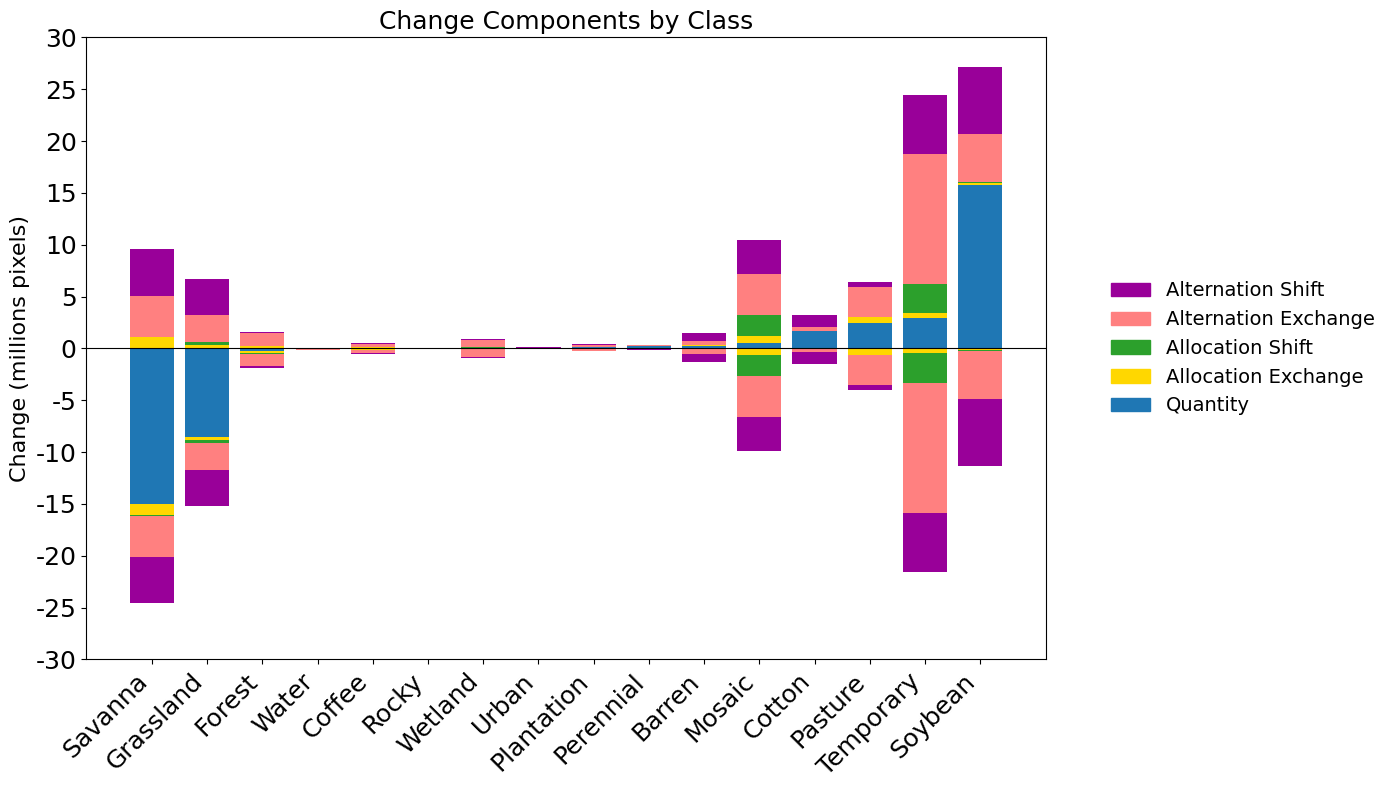

In [ ]:
class ComponentVisualizer:
    """Class to visualize components including alternation"""

    @staticmethod
    def plot_gain_loss_stacked(class_labels_dict, title, output_path):
        """Plot gains and losses with alternation components"""
        # Access predefined parameters from global scope
        global df, components_color, component_order
        global figsize, title_fontsize, label_fontsize, tick_labelsize, legend_fontsize

        # Filter data using original criteria
        filtered_df = df[df['Time_Interval'].isin(['extent', 'alternation'])]

        # Class sorting logic
        existing_classes = [cls for cls in filtered_df['Class'].unique() if cls != 0]
        class_totals = []

        # Define colors and component order
        components_color = {
            'Quantity': '#1f77b4',
            'Allocation_Exchange': '#ffd700',
            'Alternation_Exchange': '#ff8080',
            'Allocation_Shift': '#2ca02c',
            'Alternation_Shift': '#990099'
        }

        component_order = [
            'Quantity',
            'Allocation_Exchange',
            'Allocation_Shift',
            'Alternation_Exchange',
            'Alternation_Shift'
        ]

        for cls in existing_classes:
            class_data = filtered_df[filtered_df['Class'] == cls]
            quantity_gain = class_data[class_data['Component'] == 'Quantity']['Gain'].sum()
            quantity_loss = class_data[class_data['Component'] == 'Quantity']['Loss'].sum()
            class_totals.append((cls, quantity_gain - quantity_loss))

        sorted_classes = sorted(class_totals, key=lambda x: x[1])
        ordered_classes = [cls for cls, _ in sorted_classes]

        # Create figure using predefined dimensions
        fig, ax = plt.subplots(figsize=(14, 8))
        fig.subplots_adjust(left=0.1, right=0.75)
        x_positions = np.arange(len(ordered_classes))
        width = 0.8

        # Plot each class using predefined component order
        for idx, cls in enumerate(ordered_classes):
            class_data = filtered_df[filtered_df['Class'] == cls]

            # Initialize accumulators
            gain_bottom = loss_bottom = 0

            # Plot components in original + alternation order
            for comp in ['Quantity', 'Allocation_Exchange', 'Allocation_Shift', 'Alternation_Exchange', 'Alternation_Shift']:
                # Gains
                gains = class_data[class_data['Component'] == comp]['Gain'].sum()
                ax.bar(x_positions[idx], gains, width,
                       bottom=gain_bottom,
                       color=components_color[comp],
                       edgecolor='none')
                gain_bottom += gains

                # Losses
                losses = -class_data[class_data['Component'] == comp]['Loss'].sum()
                ax.bar(x_positions[idx], losses, width,
                       bottom=loss_bottom,
                       color=components_color[comp],
                       edgecolor='none')
                loss_bottom += losses

        # Axis formatting with predefined parameters
        class_names = [class_labels_dict.get(cls, {}).get("rename", f"{cls}") for cls in ordered_classes]
        ax.set_xticks(x_positions)
        ax.set_xticklabels(class_names,
                           rotation=45,
                           ha='right',
                           fontsize=18)
        ax.axhline(0,
                   color='black',
                   linewidth=0.8)
        ax.set_ylabel(
            'Change (millions pixels)',
            fontsize=16
        )
        ax.set_title(
            title,
            fontsize=18
        )
        ax.tick_params(
            axis='both',
            which='major',
            labelsize=18
        )
        ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        # Configuring y-axis to scale with millions
        def millions_formatter(x, pos):
            return '%1.0f' % (x * 1e-6)
        ax.set_ylim(-3e7, 3e7)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(5_000_000))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

        # Legend
        legend_elements = [
            plt.Rectangle((0,0),1,1, color=components_color['Alternation_Shift'], label='Alternation Shift'),
            plt.Rectangle((0,0),1,1, color=components_color['Alternation_Exchange'], label='Alternation Exchange'),
            plt.Rectangle((0,0),1,1, color=components_color['Allocation_Shift'], label='Allocation Shift'),
            plt.Rectangle((0,0),1,1, color=components_color['Allocation_Exchange'], label='Allocation Exchange'),
            plt.Rectangle((0,0),1,1, color=components_color['Quantity'], label='Quantity')
        ]

        ax.legend(
            handles=legend_elements,
            loc='center left',
            bbox_to_anchor=(1.05, 0.5),
            fontsize=14,
            frameon=False
        )

        # Save and show plot
        plt.tight_layout()
        plt.savefig(
            os.path.join(
                output_path,
                "graphic_change_component_change_class.jpeg"),
            format='jpeg',
            dpi=300,
            bbox_inches='tight'
        )
        plt.show()

ComponentVisualizer.plot_gain_loss_stacked(
    class_labels_dict,
    "Change Components by Class",
    output_path
)

## **6. Trajectory Classification**


---
### Overview
This section provides a framework for processing and classifying pixel trajectories in raster datasets.


### 6.1 Number of Changes

In [17]:
# To avoid memory errors, we process the rasters in chunks, similar to the
# TrajectoryAnalyzer. This function reads a portion of each raster, calculates the
# number of changes for that chunk, and writes it directly to a new output file.

print("Starting memory-efficient calculation of number of changes...")

# 1. Define the path for the output raster
output_raster_path = os.path.join(output_path, 'number_of_changes.tif')

# 2. Use the first masked image as a template to get metadata
with rasterio.open(masked_image_paths[0]) as src:
    meta = src.meta.copy()
    height, width = src.shape

# 3. Update metadata for our new output file
meta.update({
    'dtype': 'uint8',      # We will be counting changes, uint8 (0-255) is sufficient
    'count': 1,            # The output is a single band raster
    'nodata': 255,         # Use 255 as NoData value, as 0 can be a valid number of changes
    'compress': 'lzw'
})

# 4. Create the new raster file on disk
with rasterio.open(output_raster_path, 'w', **meta) as dst:
    print(f"Output raster created at: {output_raster_path}")

    # 5. Define chunk size (you can adjust this based on available RAM)
    chunk_size = 512 # Process 512 rows at a time

    # 6. Iterate through the raster in chunks (rows)
    for y_start in range(0, height, chunk_size):
        y_end = min(y_start + chunk_size, height)
        chunk_height = y_end - y_start
        window = rasterio.windows.Window(0, y_start, width, chunk_height)

        # 7. Load ONLY the current chunk from all maps into a temporary stack
        chunk_stack = np.zeros((len(masked_image_paths), chunk_height, width), dtype=np.uint8)
        for i, path in enumerate(masked_image_paths):
            with rasterio.open(path) as src:
                chunk_stack[i] = src.read(1, window=window)

        # 8. Calculate number of changes for this chunk
        number_of_changes_chunk = np.zeros((chunk_height, width), dtype=np.uint8)
        for i in range(len(masked_image_paths) - 1):
            t1 = chunk_stack[i]
            t2 = chunk_stack[i+1]
            # Condition to count changes only on valid data pixels (not background)
            change_map = np.where((t1 != t2) & (t1 != 0), 1, 0).astype(np.uint8)
            number_of_changes_chunk += change_map

        # Set NoData value where the original map had no data
        # We take the mask from the first year's chunk
        background_mask = (chunk_stack[0] == 0)
        number_of_changes_chunk[background_mask] = meta['nodata']

        # 9. Write the processed chunk to the output file
        dst.write(number_of_changes_chunk, 1, window=window)

        print(f"Processed and wrote rows {y_start} to {y_end}...")

print("\nCalculation of number of changes complete and raster saved successfully!")

Starting memory-efficient calculation of number of changes...
Output raster created at: /content/drive/MyDrive/change-components/output/number_of_changes.tif
Processed and wrote rows 0 to 512...
Processed and wrote rows 512 to 1024...
Processed and wrote rows 1024 to 1536...
Processed and wrote rows 1536 to 2048...
Processed and wrote rows 2048 to 2560...
Processed and wrote rows 2560 to 3072...
Processed and wrote rows 3072 to 3584...
Processed and wrote rows 3584 to 4096...
Processed and wrote rows 4096 to 4608...
Processed and wrote rows 4608 to 5120...
Processed and wrote rows 5120 to 5632...
Processed and wrote rows 5632 to 6144...
Processed and wrote rows 6144 to 6656...
Processed and wrote rows 6656 to 7168...
Processed and wrote rows 7168 to 7680...
Processed and wrote rows 7680 to 8192...
Processed and wrote rows 8192 to 8704...
Processed and wrote rows 8704 to 9216...
Processed and wrote rows 9216 to 9728...
Processed and wrote rows 9728 to 10240...
Processed and wrote rows 1

Generating map from 'number_of_changes.tif'...


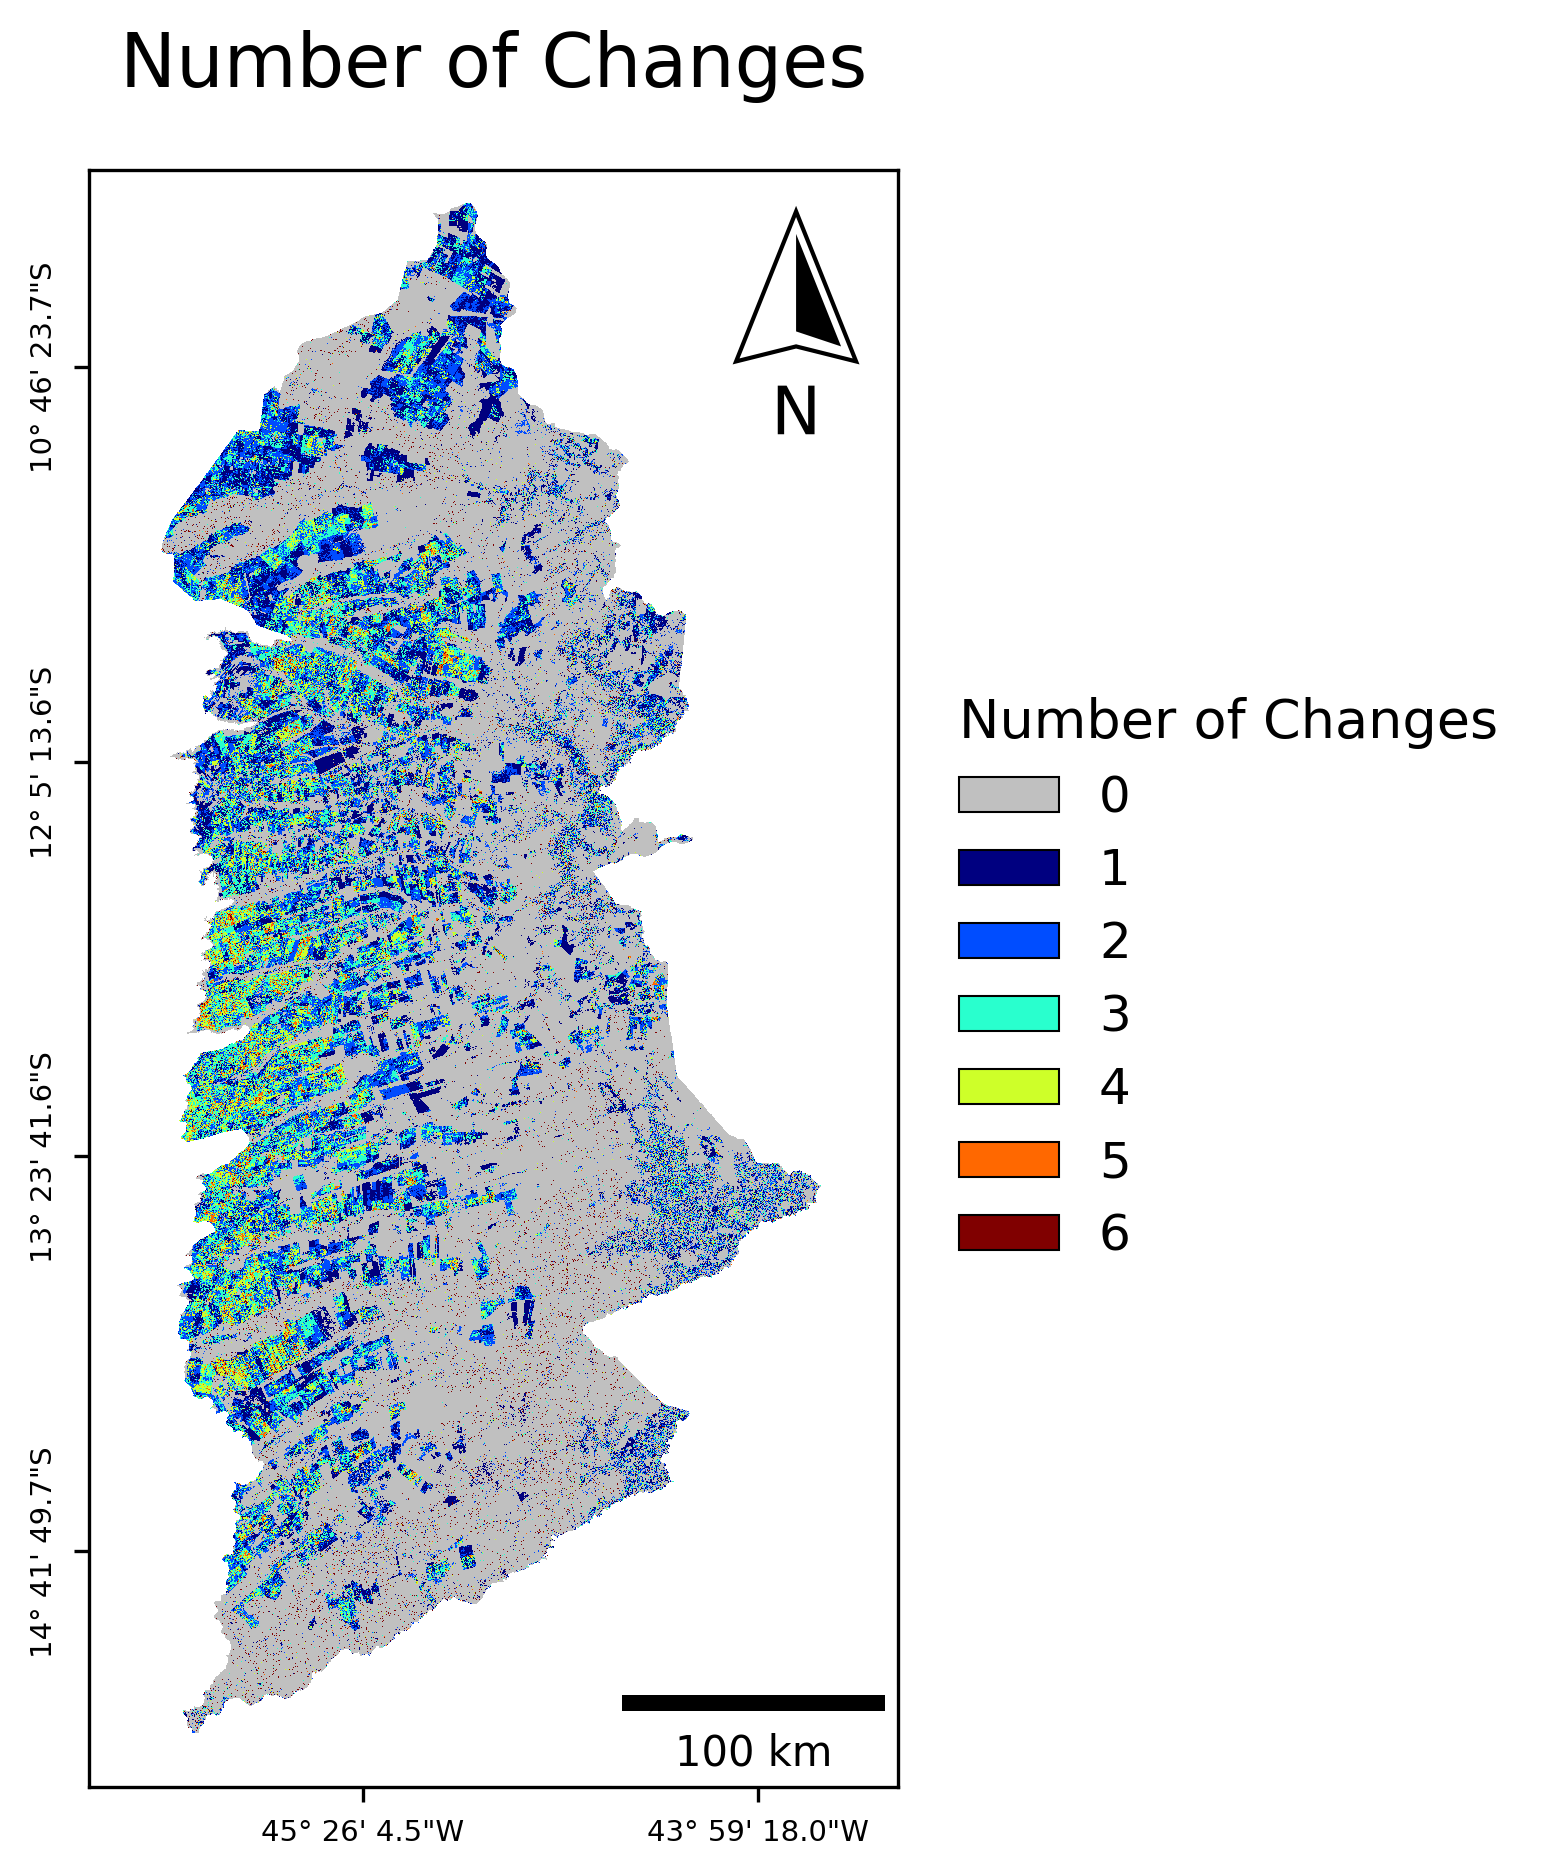


Map figure saved successfully to: /content/drive/MyDrive/change-components/output/map_number_of_changes.png


In [19]:
# This cell plots the saved raster, replicating the style of the 'Trajectories' map,
# including geographic coordinates and a discrete box legend with numeric labels.

print("Generating map from 'number_of_changes.tif'...")

# 1. Define the path to the raster we just created
# This assumes you are plotting a single file for the whole region
raster_to_plot_path = os.path.join(output_path, 'number_of_changes.tif')

# 2. Open the raster file to read its data and metadata
with rasterio.open(raster_to_plot_path) as src:
    scale_factor = 0.15
    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor)
        ),
        resampling=rasterio.enums.Resampling.nearest
    )

    nodata_value = src.nodata
    if nodata_value is not None:
        data = np.ma.masked_equal(data, nodata_value)

    left, bottom, right, top = src.bounds
    src_crs = src.crs.to_string()

# 3. Setup the coordinate transformer and formatters
transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)

def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bottom)
    deg = int(abs(lon))
    min_val = int((abs(lon) - deg) * 60)
    sec = ((abs(lon) - deg) * 60 - min_val) * 60
    return f"{deg}° {min_val}' {sec:.1f}\"" + ("E" if lon >= 0 else "W")

def format_y_ticks(y, pos):
    _, lat = transformer.transform(left, y)
    deg = int(abs(lat))
    min_val = int((abs(lat) - deg) * 60)
    sec = ((abs(lat) - deg) * 60 - min_val) * 60
    return f"{deg}° {min_val}' {sec:.1f}\"" + ("N" if lat >= 0 else "S")

# 4. Plotting setup
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)

# Get the range of change values present in the data
min_val = int(np.ma.min(data))
max_val = int(np.ma.max(data))

# --- CUSTOM COLORMAP CREATION ---
# Get the original colormap to use for values > 0
original_cmap = plt.get_cmap('jet')

# Create a new list of colors, starting with gray for the '0' value.
# We take 'max_val' colors from the original map for values 1, 2, ...
color_list = ['#c0c0c0'] + [original_cmap(i) for i in np.linspace(0, 1, max_val)]

# Create the new custom colormap
cmap = ListedColormap(color_list)
# --- END OF CUSTOMIZATION ---

# Create a norm to map each integer value to a distinct color
bounds = np.arange(min_val, max_val + 2) - 0.5
norm = BoundaryNorm(bounds, cmap.N)

# 5. Plot the raster data using the new colormap and normalization
im = ax.imshow(data,
               extent=[left, right, bottom, top],
               cmap=cmap,
               interpolation='none',
               norm=norm)

# 6. Generate the discrete box legend with the correct colors
legend_elements = []
for i in range(min_val, max_val + 1):
    color = cmap(norm(i))
    label = str(i)
    legend_elements.append(Patch(facecolor=color, label=label, edgecolor='black', linewidth=0.5))

ax.legend(handles=legend_elements,
          title='Number of Changes',
          loc='center left',
          bbox_to_anchor=(1.02, 0.5),
          frameon=False,
          fontsize=12,
          title_fontsize=13,
          alignment='left'
          )

# 7. Add cartographic elements
scalebar = ScaleBar(1/1000,
                    units='km',
                    length_fraction=0.4,
                    location='lower right',
                    scale_formatter=lambda value, _: f"{int(value)} km")
ax.add_artist(scalebar)
north_arrow(ax,
            location="upper right",
            shadow=False,
            rotation={"degrees":0})

# 8. Final styling to match the trajectory map
ax.set_title('Number of Changes', fontsize=18, pad=20)
ax.set_aspect('equal')
ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
ax.tick_params(axis='x', which='major', labelsize=7, pad=4)
ax.tick_params(axis='y', which='major', labelsize=7, pad=4)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
plt.setp(ax.get_yticklabels(), rotation=90, va="center")

# 9. Save the figure
output_figure_path = os.path.join(output_path, 'map_number_of_changes.png')
plt.savefig(output_figure_path,
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.5
            )

plt.show()

print(f"\nMap figure saved successfully to: {output_figure_path}")

### 6.2 Trajectory Analysis

This section processes and visualizes raster data by scaling, applying a color map, and adding graphical elements like legends, scale bars, and north arrows. The output is a high-resolution image of the classified raster data.

In [ ]:
#------------------------------------------------------------------------------------------------
# Trajectory Classification
#------------------------------------------------------------------------------------------------

@nb.njit(nogil=True)
def classify_pixel(pixel_series):
    """Numba-optimized trajectory classification (20-50x faster)"""
    if pixel_series[0] == 0:
        return 0

    start = pixel_series[0]
    end = pixel_series[-1]

    has_variation = False
    direct_transition = False

    # First pass: check all conditions in single Loop
    for i in range(len(pixel_series) - 1):
        current = pixel_series[i]
        next_val = pixel_series[i+1]

        # Check for any variation
        if not has_variation and current != next_val:
            has_variation = True

        # Check for direct transition
        if not direct_transition and current == start and next_val == end:
            direct_transition = True

    # Trajectory 1:
    if not has_variation:
        return 1

    # Trajectory 2:
    if start == end:
        return 2

    # Trajectory 3:
    if direct_transition:
        return 3

    # Trajectory 4:
    return 4

@nb.njit(nogil=True, parallel=True)
def process_stack_parallel(stack, height, width):
    """Parallel processing of raster stack"""
    result = np.zeros((height, width), dtype=np.uint8)
    for y in prange(height):
        for x in range(width):
            result[y, x] = classify_pixel(stack[:, y, x])
    return result

class TrajectoryAnalyzer:
    @staticmethod
    def process_rasters(output_path, suffix='_masked.tif'):
        """Optimized raster processing with chunked loading"""
        os.makedirs(output_path, exist_ok=True)
        if not os.path.isdir(output_path):
            raise ValueError(f"Path must be a directory: {output_path}")

        raster_files = sorted([
            os.path.join(output_path, f)
            for f in os.listdir(output_path)
            if f.endswith(suffix)
        ])

        if not raster_files:
            raise ValueError(f"No files found with suffix '{suffix}'")

        with rasterio.open(raster_files[0]) as src:
            meta = src.meta
            height, width = src.shape

        chunk_size = 500
        result = np.zeros((height, width), dtype=np.uint8)

        print(f"Starting processing of {height} rows in chunks of {chunk_size}...")

        for y_start in range(0, height, chunk_size):
            y_end = min(y_start + chunk_size, height)
            chunk_height = y_end - y_start

            stack = np.zeros((len(raster_files), chunk_height, width), dtype=np.uint8)
            for i, f in enumerate(raster_files):
                with rasterio.open(f) as src:
                    stack[i] = src.read(1, window=((y_start, y_end), (0, width)))

            result[y_start:y_end] = process_stack_parallel(stack, chunk_height, width)

            # Added line for progress feedback
            print(f"  > Processed rows {y_start} to {y_end}...")

        meta.update({
            'dtype': 'uint8', 'nodata': 0, 'count': 1, 'compress': 'lzw'
        })
        output_file = os.path.join(output_path, 'trajectory.tif')
        with rasterio.open(output_file, 'w', **meta) as dst:
            dst.write(result, 1)

        return output_file

In [ ]:
#------------------------------------------------------------------------------------------------
# Run Trajectory Analysis
#------------------------------------------------------------------------------------------------

print("Starting trajectory analysis...")

# This line calls the function defined in the previous cell.
# It requires the 'output_path' variable to be defined.
trajectory_file = TrajectoryAnalyzer.process_rasters(output_path)

print(f"\nProcessing complete! Results saved to: {trajectory_file}")

Starting trajectory analysis...
Starting processing of 20480 rows in chunks of 500...
  > Processed rows 0 to 500...
  > Processed rows 500 to 1000...
  > Processed rows 1000 to 1500...
  > Processed rows 1500 to 2000...
  > Processed rows 2000 to 2500...
  > Processed rows 2500 to 3000...
  > Processed rows 3000 to 3500...
  > Processed rows 3500 to 4000...
  > Processed rows 4000 to 4500...
  > Processed rows 4500 to 5000...
  > Processed rows 5000 to 5500...
  > Processed rows 5500 to 6000...
  > Processed rows 6000 to 6500...
  > Processed rows 6500 to 7000...
  > Processed rows 7000 to 7500...
  > Processed rows 7500 to 8000...
  > Processed rows 8000 to 8500...
  > Processed rows 8500 to 9000...
  > Processed rows 9000 to 9500...
  > Processed rows 9500 to 10000...
  > Processed rows 10000 to 10500...
  > Processed rows 10500 to 11000...
  > Processed rows 11000 to 11500...
  > Processed rows 11500 to 12000...
  > Processed rows 12000 to 12500...
  > Processed rows 12500 to 13000


Trajectory Percentages:
Trajectory 1: 58.01%
Trajectory 2: 5.81%
Trajectory 3: 19.35%
Trajectory 4: 16.82%


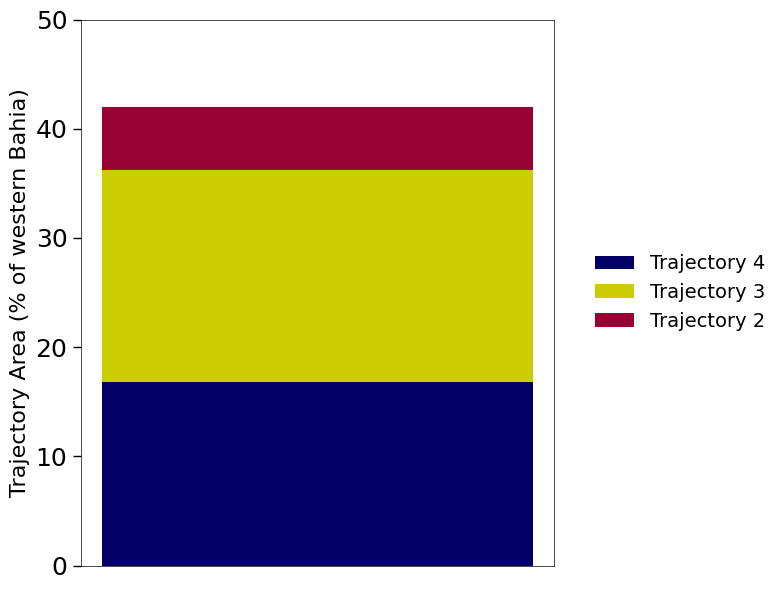

In [ ]:
def plot_trajectory_distribution(output_path):
    """
    Generates trajectory distribution bar chart from raster data
    with consistent styling and proper frame
    """
    # Path to trajectory raster
    raster_path = os.path.join(output_path, 'trajectory.tif')

    # Read raster data
    with rasterio.open(raster_path) as src:
        traj_data = src.read(1)
        nodata = src.nodata

    # Filter nodata values and count trajectories
    masked_traj = np.ma.masked_where(traj_data == nodata, traj_data)
    unique, counts = np.unique(masked_traj.compressed(), return_counts=True)
    total_pixels = counts.sum()

    # Calculate percentages
    percentages = {k: (v/total_pixels)*100 for k, v in zip(unique, counts)}

    # Print trajectory percentages
    print("\nTrajectory Percentages:")
    for traj, percentage in percentages.items():
        print(f"Trajectory {traj}: {percentage:.2f}%")

    # Define trajectories to show (4, 3, 2) and colors
    ordered_trajs = [4, 3, 2]
    colors = {
        4: '#000066',  # Dark blue
        3: '#cccc00',  # Gold
        2: '#990033'   # Dark red
    }

    # Calculate maximum Y value (round up to nearest 10)
    max_percentage = sum(percentages.get(traj, 0) for traj in ordered_trajs)
    y_max = np.ceil(max_percentage / 10) * 10  # Round up to nearest 10

    # Create figure with consistent styling
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot stacked bars
    bottom = 0
    for traj in ordered_trajs:
        if traj in percentages:
            ax.bar(0, percentages[traj],
                  bottom=bottom,
                  color=colors[traj],
                  width=0.4,
                  edgecolor='none')
            bottom += percentages[traj]

    # Formatting labels
    ax.set_ylabel('Trajectory Area (% of western Bahia)',
                 fontsize=16)

    # Configure frame (box) - all spines visible
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(0.5)

    # Remove minor ticks and configure major ticks
    ax.tick_params(
        axis='y',
        which='minor',
        length=0
        )
    ax.tick_params(
        axis='y',
        which='major',
        labelsize=18,
        length=6,
        width=1
        )

    # Set dynamic Y-axis limits
    ax.set_ylim(0, y_max)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(np.floor(y_max/5)))

    ax.xaxis.set_visible(False)

    # Remove grid lines
    ax.grid(False)

    # Legend
    legend_elements = [
        Patch(facecolor='#000066', label='Trajectory 4'),
        Patch(facecolor='#cccc00', label='Trajectory 3'),
        Patch(facecolor='#990033', label='Trajectory 2')
    ]
    ax.legend(handles=legend_elements,
             loc='center left',
             bbox_to_anchor=(1.05, 0.5),
             fontsize=14,
             frameon=False)

    # Save and show
    plt.tight_layout()
    plt.savefig(os.path.join(
        output_path,
        'trajectory_distribution.jpeg'),
                dpi=300,
                bbox_inches='tight')
    plt.show()

# Usage
if __name__ == "__main__":
    plot_trajectory_distribution(output_path)

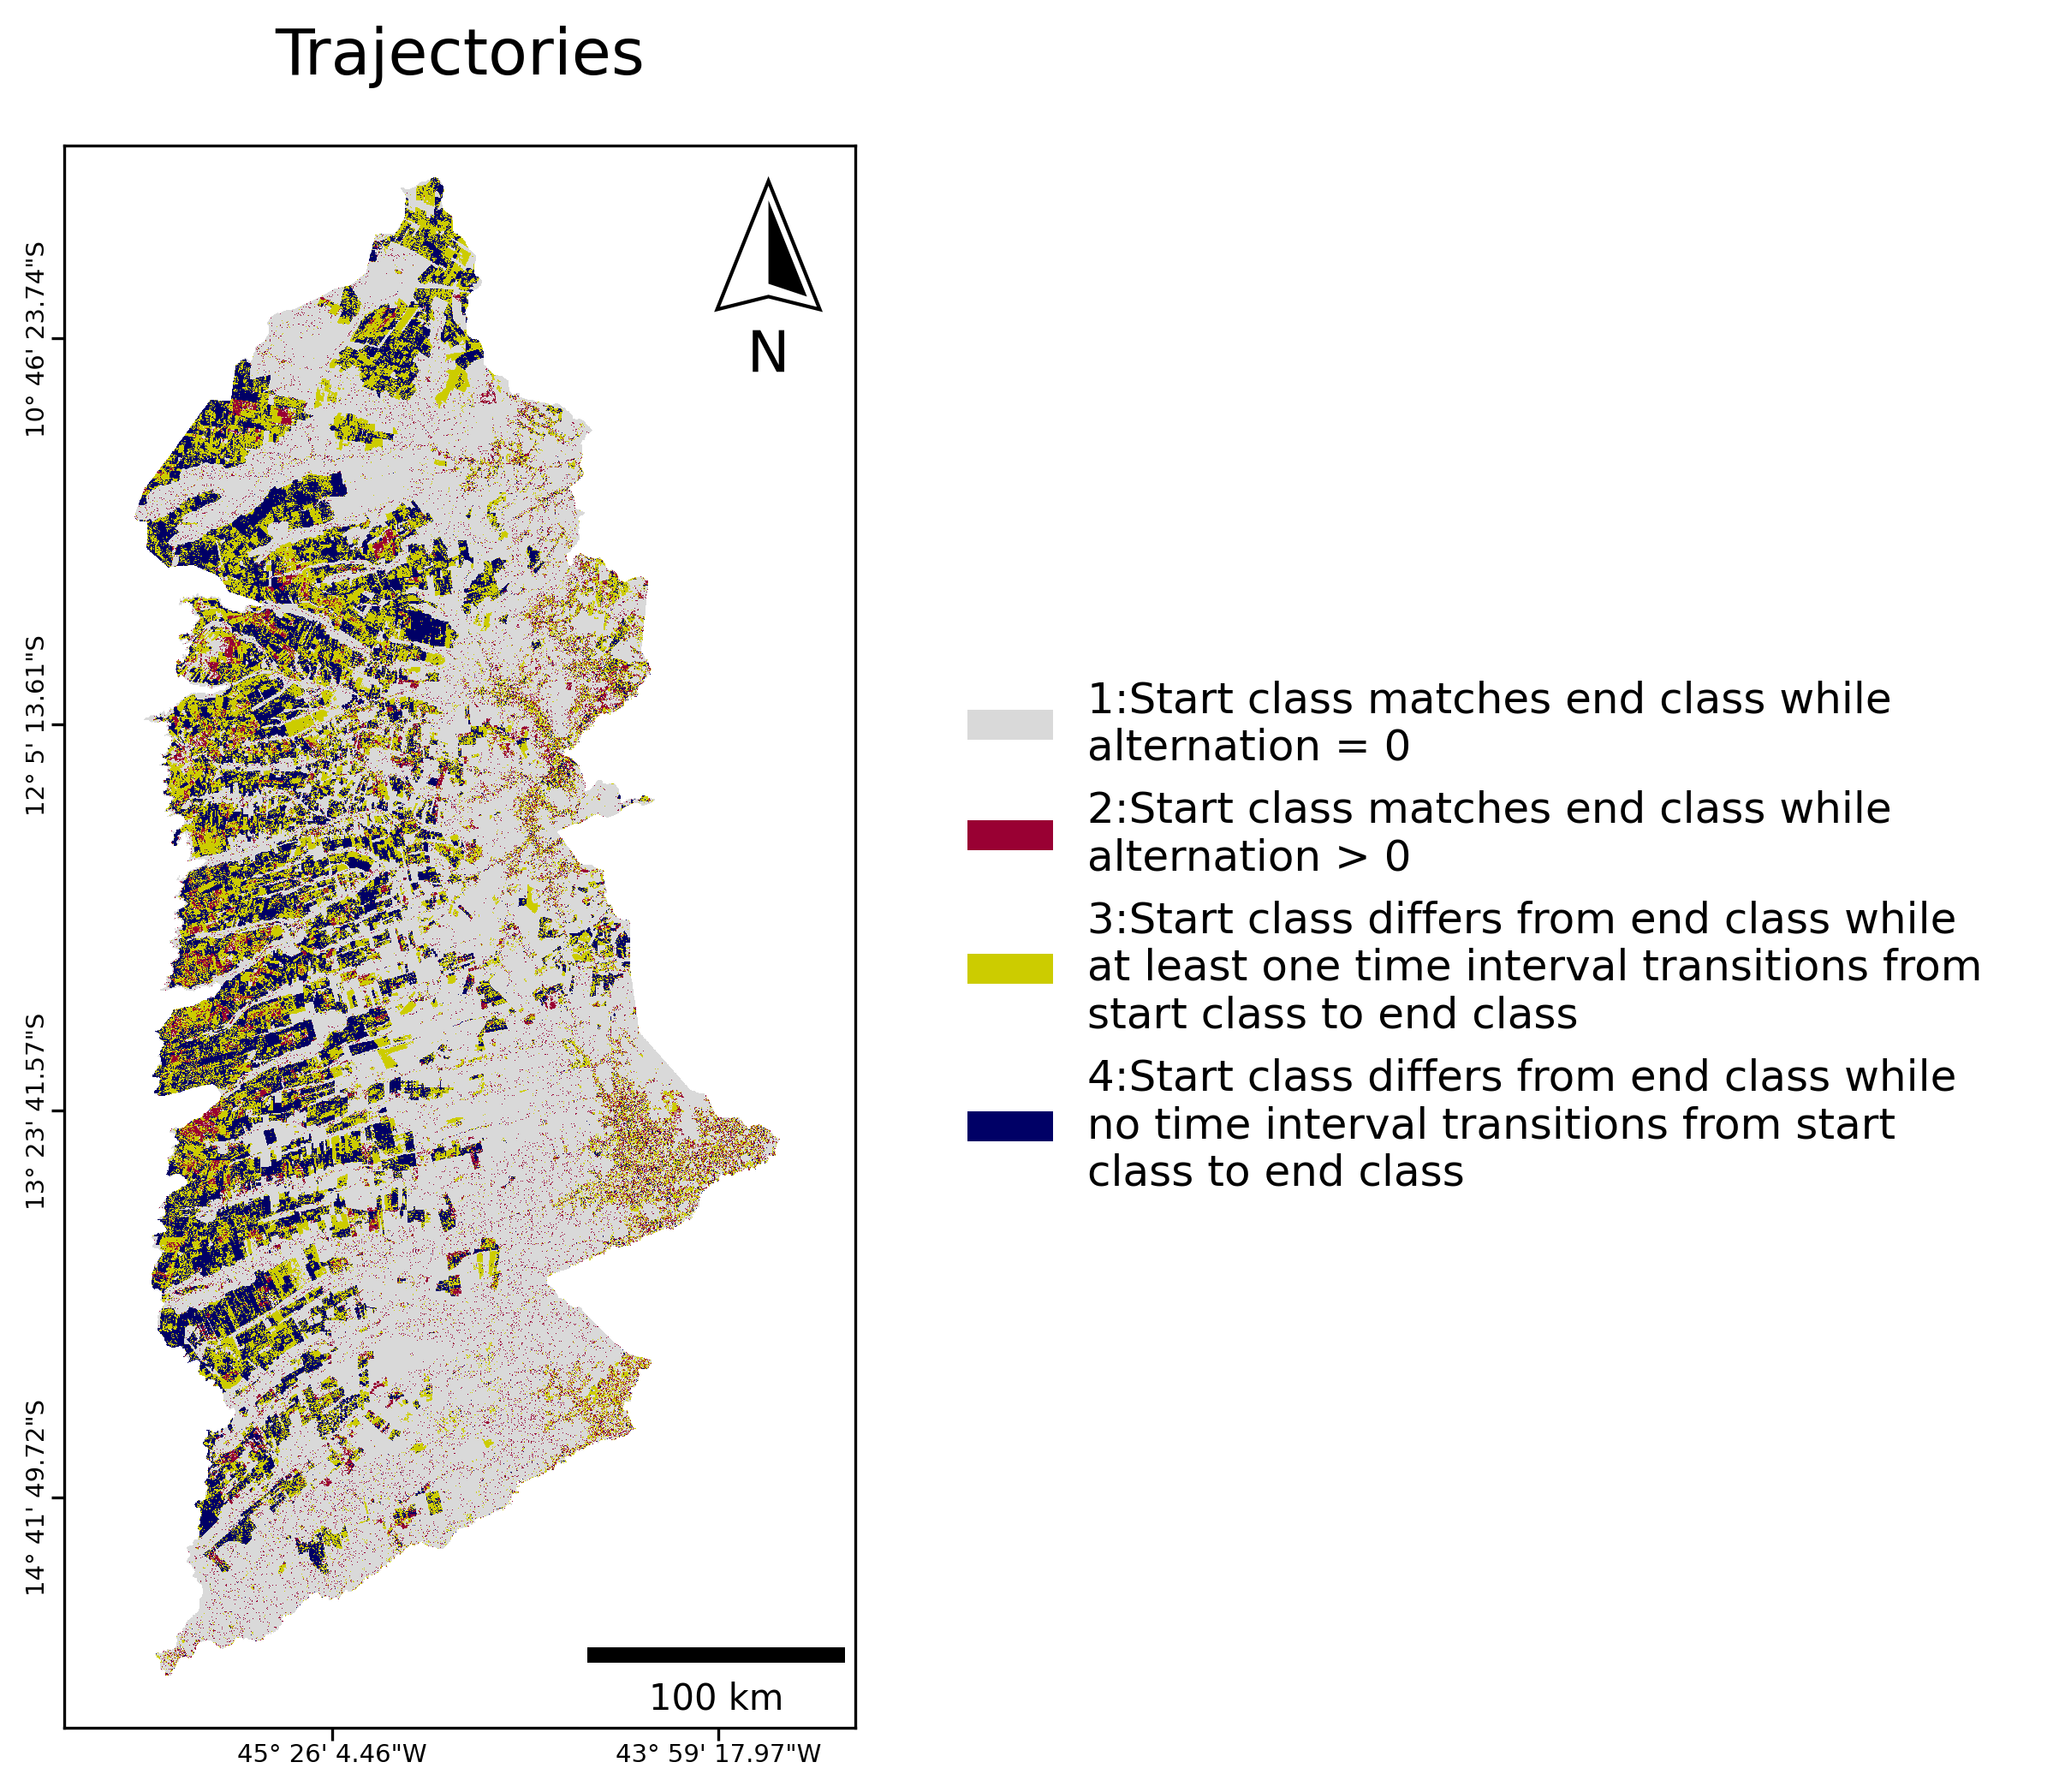

Map saved successfully in the folder: /content/drive/MyDrive/change-components/output


In [ ]:
# Set the path for the input raster file
raster_path = os.path.join(output_path, 'trajectory.tif')

# Set the resolution quality of the output image
dpi = 300

# Define a scale factor to resize the raster data
scale_factor = 0.15

# Legend elements for the trajectory map
legend_elements = [
    Rectangle((0, 0), 1, 1, facecolor='#d9d9d9', label='1:Start class matches end class while\nalternation = 0'),
    Rectangle((0, 0), 1, 1, facecolor='#990033', label='2:Start class matches end class while\nalternation > 0'),
    Rectangle((0, 0), 1, 1, facecolor='#cccc00', label='3:Start class differs from end class while\nat least one time interval transitions from\nstart class to end class'),
    Rectangle((0, 0), 1, 1, facecolor='#000066', label='4:Start class differs from end class while\nno time interval transitions from start\nclass to end class')
]

# Colormap for the trajectory map
cmap = ListedColormap([
    '#ffffff',
    '#d9d9d9',
    '#990033',
    '#cccc00',
    '#000066',
])

with rasterio.open(raster_path) as src:
    # Read and scale data
    data = src.read(
        1,
        out_shape=(int(src.height * scale_factor), int(src.width * scale_factor)),
        resampling=rasterio.enums.Resampling.nearest
    )

    # Get bounds and CRS
    left, bottom, right, top = src.bounds
    src_crs = src.crs.to_string()

    # Create coordinate transformer
    transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8), dpi=dpi)

    # Plot raster data
    img = ax.imshow(
        data,
        cmap=cmap,
        extent=[left, right, bottom, top],
        interpolation='none'
    )

    # Custom tick formatters for degrees
    def format_x_ticks(x, pos):
        lon, _ = transformer.transform(x, bottom)
        deg = int(abs(lon))
        min_val = int((abs(lon) - deg) * 60)
        sec = ((abs(lon) - deg) * 60 - min_val) * 60
        return f"{deg}° {min_val}' {sec:.2f}\"" + ("E" if lon >= 0 else "W")

    def format_y_ticks(y, pos):
        _, lat = transformer.transform(left, y)
        deg = int(abs(lat))
        min_val = int((abs(lat) - deg) * 60)
        sec = ((abs(lat) - deg) * 60 - min_val) * 60
        return f"{deg}° {min_val}' {sec:.2f}\"" + ("N" if lat >= 0 else "S")

    ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))

    # Add scale bar
    scalebar = ScaleBar(
        1/1000,
        units='km',
        length_fraction=0.4,
        location='lower right',
        scale_formatter=lambda value, _: f"{int(value)} km"
    )
    ax.add_artist(scalebar)

    # Add north arrow
    north_arrow(
        ax,
        location="upper right",
        shadow=False,
        rotation={"degrees": 0}
    )

    # Style adjustments
    ax.set_aspect('equal')
    ax.tick_params(axis='x', which='major', labelsize=7, pad=4)
    ax.tick_params(axis='y', which='major', labelsize=7, pad=4)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    plt.setp(ax.get_yticklabels(), rotation=90, va='center')
    plt.title("Trajectories", fontsize=18, pad=20)

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_horizontalalignment('center')
        label.set_verticalalignment('center')

    # Add Legend
    ax.legend(
        handles=legend_elements,
        loc='center left',
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
        fontsize=12,
        borderpad=1.2,
        handletextpad=0.8,
        columnspacing=2
    )

    # Save the plot as a JPEG file
    plt.savefig(
        os.path.join(output_path, 'map_trajectories_degree.jpeg'),
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0.5,
        pil_kwargs={'optimize': True, 'quality': 95}
    )

    plt.show()
    plt.close()

print("Map saved successfully in the folder:", output_path)